# Perfectly matched layers (PML)

## The basics


## Application to the linear Schrödinger equation using spectral methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres

## A spectral Crank-Nicolson scheme using GMRES (even though it is not required without the PML layer)

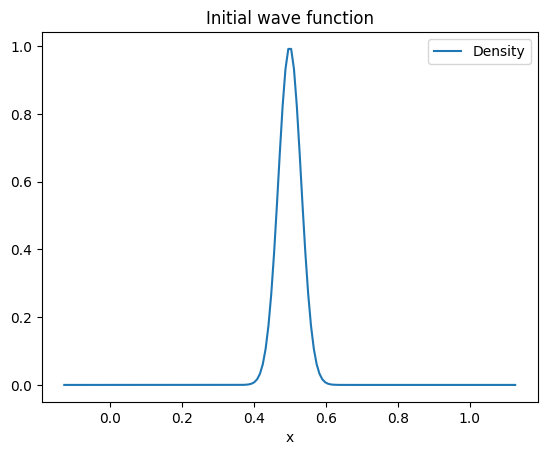

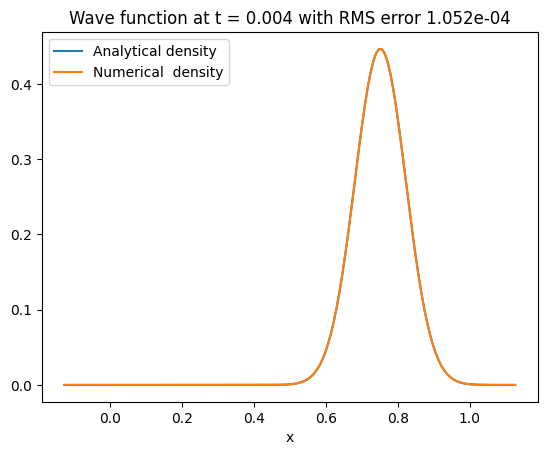

In [2]:
L                 = 1                                               # size of physical domain
N_boundary        = 16                                              # number of points in PML boundary 
N                 = 128                                             # number of points in physical domain 
dx                = L/(N - 1)
x                 = np.arange(-N_boundary, N + N_boundary) * dx
x0                = x[0]
x1                = x[-1]
N_PML             = len(x) 
L_PML             = N_PML * dx
inner             = range(N_boundary, N_PML - N_boundary)
k                 = np.fft.ifftshift(2*np.pi / L_PML * np.arange(-N_PML/2, N_PML/2)) # momentum grid
t                 = 0.0
dt                = 0.2 * dx**2 
tend              = 0.004
fdl               = 1
fdr               = 0
counter           = 0 


def gaussianWave(x, t, m = 1, hbar = 1, alpha= 1/500, k= 20*np.pi, x0=.5):
    C = np.sqrt(alpha / (alpha + 1.0j * t * hbar/m))
    psi = (
        C
        * np.exp(-((x - x0 - 1.0j * k * alpha) ** 2) / (2 * (alpha + 1.0j * t * hbar/m)))
        * np.exp(-(alpha * k ** 2) / 2)
    )
    return psi

psi = gaussianWave(x,t)

class gmres_counter(object):
    def __init__(self, disp=True):
        self._disp = disp
        self.niter = 0
    def __call__(self, rk=None):
        self.niter += 1
        if self._disp:
            print('iter %3i\trk = %s' % (self.niter, str(rk)))

plt.title("Initial wave function") 
plt.plot(x, np.abs(psi)**2, label="Density")
plt.xlabel("x")
plt.legend()
plt.show() 

while t < tend:

    def LapOperator(psihat):
        Lhat    = 0.5 * psihat * k**2
        return Lhat

    def leftOperator(psihat):
        return 1j / dt * psihat - 0.5 * LapOperator(psihat)
    
    def rightOperator(psi):
        return 1j / dt * psihat + 0.5 * LapOperator(psihat)

    def preconditioner(psihat):
        return 1/(1j / dt - 0.25 * k**2) * psihat

    psihat  = scipy.fft.fft(psi)
    
    A       = LinearOperator((N_PML, N_PML), matvec =  leftOperator)
    M       = LinearOperator((N_PML, N_PML), matvec =  preconditioner)
    b       = rightOperator(psihat)

    counter = gmres_counter()
    psihat, exitCode = gmres(A,  b, tol=1e-15, M = M)#, callback=counter) 
    
    #Why is the above so much worse than unitary evolution?
    #psihat  = np.exp(-1j * dt/2 * k**2) * psihat 
    psi     = scipy.fft.ifft(psihat)



    t += dt

numdens = np.abs(psi)**2
anadens = np.abs(gaussianWave(x, t))**2 
plt.title(f"Wave function at t = {t:3.3f} with RMS error {np.sqrt(np.mean((numdens-anadens)**2)):3.3e}") 
#plt.plot(x, np.real(psi), label=f"Real  part")
#plt.plot(x, np.imag(psi), label=f"Imag. part")
plt.plot(x, anadens, label="Analytical density")
plt.plot(x, numdens, label="Numerical  density")
plt.xlabel("x")
plt.legend()
plt.show() 


## The spectral Crank-Nicolson PML scheme using GMRES

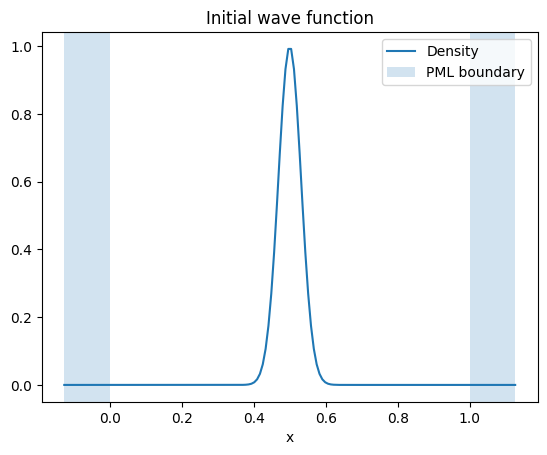

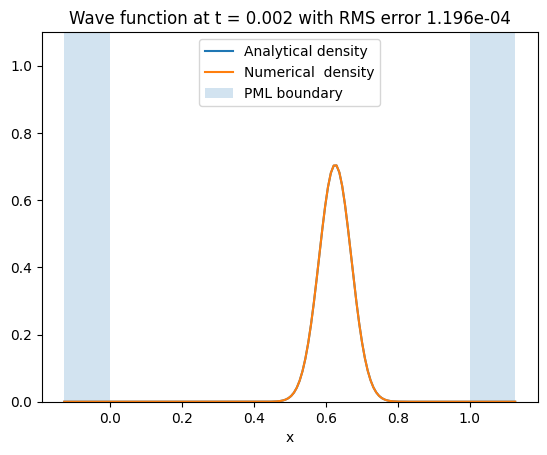

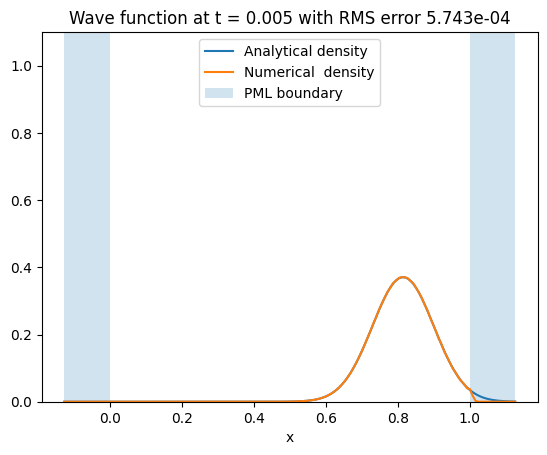

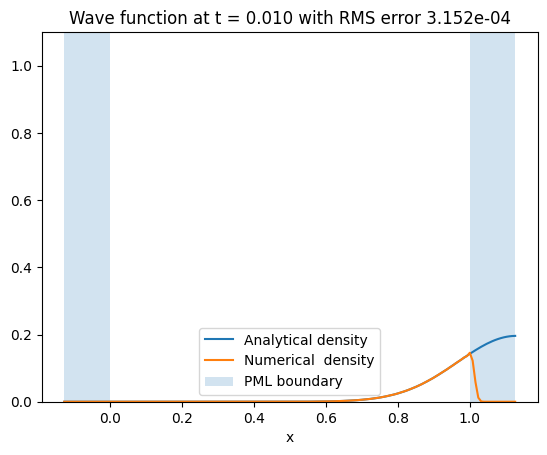

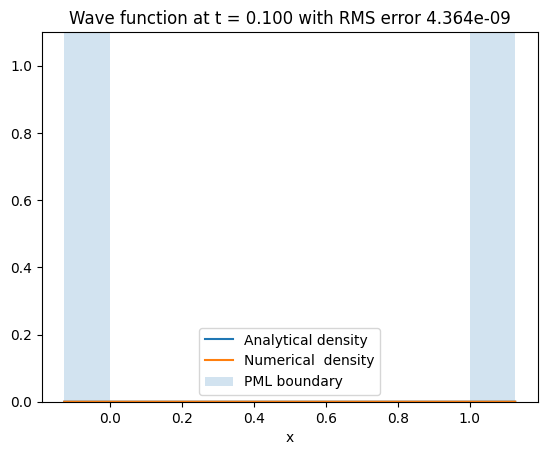

In [3]:
#Define the abos

def sigma1_func(x, sigma0, delta):
    return sigma0 * ( x + delta ) ** 2


def dsigma1_func(x, sigma0, delta):
    return 2 * sigma0 *  ( x + delta )


def sigma2_func(x, sigma0, delta):
    return sigma0 * ( x + delta ) ** 3


def dsigma2_func(x, sigma0, delta):
    return 3 * sigma0 *  ( x + delta ) ** 2


def sigma3_func(x, sigma0, delta):
    return - sigma0 / x 


def dsigma3_func(x, sigma0, delta):
    return sigma0 / x**2 


def sigma4_func(x, sigma0, delta):
    return sigma0 / x**2


def dsigma4_func(x, sigma0, delta):
    return (-2) * sigma0 / x**3


def sigma5_func(x, sigma0, delta):
    return - sigma0 / x - sigma0 / delta


def dsigma5_func(x, sigma0, delta):
    return sigma0 / x**2


def sigma6_func(x, sigma0, delta):
    return sigma0 / x**2 - sigma0 / delta**2


def dsigma6_func(x, sigma0, delta):
    return (-2) * sigma0 / x**3

sigma_funcs  = [ sigma1_func,  sigma2_func,  sigma3_func,  sigma4_func,  sigma5_func,  sigma6_func]
dsigma_funcs = [dsigma1_func, dsigma2_func, dsigma3_func, dsigma4_func, dsigma5_func, dsigma6_func]

def S_func(x, L0_phys, L0_PML, L1_phys, L1_PML, sigma0, sigma_func, gamma = np.pi/4):
    y = np.ones(x.shape, complex)
    delta = L1_PML - L1_phys


    y[x <= L0_phys] = 1 + np.exp(1j * gamma) * sigma_func(-np.abs(x[x <= L0_phys] - L0_PML + 1e-8), sigma0, delta)
    y[x >= L1_phys] = 1 + np.exp(1j * gamma) * sigma_func(-np.abs(x[x >= L1_phys] - L1_PML + 1e-8), sigma0, delta)
    return y

def dS_func(x, L0_phys, L0_PML, L1_phys, L1_PML, sigma0, dsigma_func, gamma = np.pi/4):
    y = np.zeros(x.shape, complex)
    delta = L1_PML - L1_phys

    y[x <= L0_phys] = np.exp(1j * gamma) * (-1) * np.sign(x[x <= L0_phys] - L0_PML) * dsigma_func(-np.abs(x[x <= L0_phys] - L0_PML), sigma0, delta)
    y[x >= L1_phys] = np.exp(1j * gamma) * (-1) * np.sign(x[x >= L1_phys] - L1_PML) * dsigma_func(-np.abs(x[x >= L1_phys] - L1_PML), sigma0, delta)
    return y

t      = 0
tend   = 0.1
sigma0 = 0.1
S      = S_func(x, 0, x0, L, x1, sigma0, sigma_funcs[5])
psi    = gaussianWave(x,t)

plt.title("Initial wave function") 
plt.plot(x, np.abs(psi)**2, label="Density")
plt.axvspan(x0,  0, alpha=0.2, label="PML boundary")
plt.axvspan(L , x1, alpha=0.2)
plt.xlabel("x")
plt.legend()
plt.show() 

dump_times = [0.002, 0.005, 0.01, 0.1]
cur_dump   = 0

while t < tend:

    def LapOperator(psihat):
        L_psihat    = psihat * k * 1j
        L_psi       = scipy.fft.ifft(L_psihat) / S
        L_psihat    = scipy.fft.fft(L_psi)
        L_psihat    = L_psihat * k * 1j
        L_psi       = scipy.fft.ifft(L_psihat) / S
        Lhat        = scipy.fft.fft(L_psi)
        return -0.5 * Lhat

    def leftOperator(psihat):
        return 1j / dt * psihat - 0.5 * LapOperator(psihat)
    
    def rightOperator(psi):
        return 1j / dt * psihat + 0.5 * LapOperator(psihat)
    
    def preconditioner(psihat):
        return 1/(1j / dt - 0.25 * k**2) * psihat

    psihat  = scipy.fft.fft(psi)
    
    A       = LinearOperator((N_PML, N_PML), matvec =  leftOperator)
    M       = LinearOperator((N_PML, N_PML), matvec =  preconditioner)
    b       = rightOperator(psihat)

    counter = gmres_counter()
    psihat, exitCode = gmres(A,  b, tol=1e-15, M = M)#, callback=counter) 

    psi     = scipy.fft.ifft(psihat)



    t += dt

    if t > dump_times[cur_dump]:
        cur_dump += 1

        numdens = np.abs(psi)**2
        anadens = np.abs(gaussianWave(x, t))**2 
        plt.title(f"Wave function at t = {t:3.3f} with RMS error {np.sqrt(np.mean(((numdens-anadens)[inner])**2)):3.3e}") 
        #plt.plot(x, np.real(psi), label=f"Real  part")
        #plt.plot(x, np.imag(psi), label=f"Imag. part")
        plt.plot(x, anadens, label="Analytical density")
        plt.plot(x, numdens, label="Numerical  density")
        plt.ylim([0, 1.1])
        plt.axvspan(x0,  0, alpha=0.2, label="PML boundary")
        plt.axvspan(L , x1, alpha=0.2)
        plt.xlabel("x")
        plt.legend()
        plt.show() 


## Systematic test of different absorbers

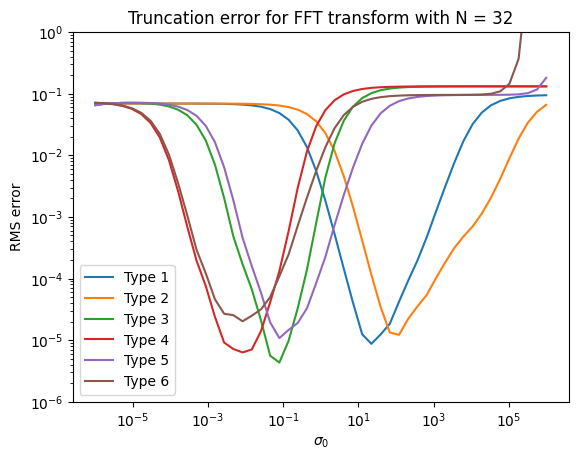

In [5]:
resolutions    = 2**np.arange(5, 6)

for j, resolution in enumerate(resolutions):
    plt.title(f"Truncation error for FFT transform with N = {resolution}")
    for i in range(6):
        sigmas = np.logspace(-6, 6, 50)
        errors = []
        for sigma in sigmas:
            L                 = 1                                                                # size of physical domain
            N_boundary        = 8 * 2**j                                                         # number of points in PML boundary 
            N                 = resolution                                                       # number of points in physical domain 
            dx                = L/(N - 1)
            x                 = np.arange(-N_boundary, N + N_boundary) * dx
            x0                = x[0]
            x1                = x[-1]
            N_PML             = len(x) 
            L_PML             = N_PML * dx
            inner             = range(N_boundary, N_PML - N_boundary)
            k                 = np.fft.ifftshift(2*np.pi / L_PML * np.arange(-N_PML/2, N_PML/2)) # momentum grid
            t                 = 0.0
            dt                = 0.2 * dx**2 
            t                 = 0
            tend              = 0.1
            sigma0            = 0.1
            S                 = S_func(x, 0, x0, L, x1, sigma, sigma_funcs[i])
            psi               = gaussianWave(x,t)


            
            while t < tend:

                def LapOperator(psihat):
                    L_psihat    = psihat * k * 1j
                    L_psi       = scipy.fft.ifft(L_psihat) / S
                    L_psihat    = scipy.fft.fft(L_psi)
                    L_psihat    = L_psihat * k * 1j
                    L_psi       = scipy.fft.ifft(L_psihat) / S
                    Lhat        = scipy.fft.fft(L_psi)
                    return -0.5 * Lhat

                def leftOperator(psihat):
                    return 1j / dt * psihat - 0.5 * LapOperator(psihat)
                
                def rightOperator(psi):
                    return 1j / dt * psihat + 0.5 * LapOperator(psihat)
                
                def preconditioner(psihat):
                    return 1/(1j / dt - 0.25 * k**2) * psihat

                psihat  = scipy.fft.fft(psi)
                
                A       = LinearOperator((N_PML, N_PML), matvec =  leftOperator)
                M       = LinearOperator((N_PML, N_PML), matvec =  preconditioner)
                b       = rightOperator(psihat)

                psihat, exitCode = gmres(A,  b, tol=1e-15, M = M)

                psi     = scipy.fft.ifft(psihat)

                t       += dt


            numdens = np.abs(psi)**2
            anadens = np.abs(gaussianWave(x, t))**2 
            errors.append(np.sqrt(np.mean(((numdens-anadens)[inner])**2)))

        plt.ylim([1e-6, 1])
        plt.loglog(sigmas, errors, label = f"Type {i+1}")

    plt.ylabel("RMS error")
    plt.xlabel(r"$\sigma_0$")
    plt.legend()
    plt.show()
